# LSTM for Player Entity Embeddings

The aim of this project is to deduce the playing style and similarities among European football players using the Wyscout dataset. To achieve objective and data-driven outcomes, we implement an LSTM (Long Short-Term Memory) model on sequential game data. This model leverages past moments within the game to forecast subsequent actions, thereby generating valuable player entity embeddings that infer their playing characteristics.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the Wyscout data.
FOLDERNAME = 'real_madrid/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

%cd drive/MyDrive/real_madrid_new

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12iOjjQZN-Q6XGa8zpqXxVhbqgQLcZE0i/real_madrid_new


In [ ]:
import json
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import copy
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from tensorflow.keras import Model, metrics
from tensorflow.keras.layers import (LSTM, Dropout, Dense, Input, Embedding,
                                     Concatenate, Reshape)
games_dir = 'wyscout-soccer-match-event-dataset/processed/files'

If the data has not been processed, then run this cell:

In [ ]:
#!python data_formatting.py

### Identify relevant players

In the data_formatting.py file, we identify the most impactful players in the dataset by determining those within the top 75% quantile in terms of touches. Moving forward, our analysis will focus solely on these players, as their extensive data presence suggests they possess significant player style embeddings that are worth exploring. Conversely, players with only a few touches on the ball are unlikely to have meaningful embeddings and will therefore not be included in our analysis.

In [ ]:
#read in only relevant players
with open('players_clean_quantile.csv', newline='') as f:
    reader = csv.reader(f)
    relevant_players = list(reader)[0]
    relevant_players = [int(i) for i in relevant_players]

# 0 indexing of players for categorical encoding
playerID0index = {0:0}
for i in range(len(relevant_players)):
  playerID0index[int(relevant_players[i])] = i+1

### Split the data into 80% for training purposes and 20% for testing the model

In [ ]:
# make train and test sets
games_list = os.listdir('processed_games/')
train_games = random.sample(games_list, int(len(games_list)*.8))
test_games = list(set(games_list) - set(train_games))

### Chunk the data

To prepare our data for the LSTM model, we need to transform the dataframe into 3D numpy arrays. The model will utilize features from n previous timesteps to predict the subsequent SUBEVENT at timestep n+1. Consequently, our y values consist of integer-encoded subevents, making this a multi-class classification task with 36 distinct subevents. Despite the complexity of this classification, our goal is to enable the model to precisely anticipate the next event in a sequence.

It's noteworthy that the model can be trained using quite large number of timesteps_before to predict the subsequent subevent, potentially enhancing its ability to encode long-term memory. However, due to the computational constraints of this project, we opted to train it using a limited range of timesteps_before (3-5).

In [ ]:
def chunk_data(game_id, timesteps_before, player_dict):
    """Convert one game df into 3D numpy arrays comaptible with the LSTM.

    Reshape input to the following:
        x: (samples, timesteps_before, features)
        y: (samples,)
    Each of these chunks represents all feature of timesteps_before actions. The
    y value for each chunk is the subeventId of the following action. However,
    some of these events may involve players that are not in the top 75% of our
    dataset. In this case, we will delete the chunks that involve unrelevant
    players.

    Input:
        game_id (str): unique game id
        timesteps_before (int): the number of actions to take into account
                                before a prediction
        player_dict: the 0-indexed player dict of relevant players

    Output:
        x_subEvent (array of shape (num_samples, timesteps_before)): integer
            encoded subevent for every timestep in the chunk
        x_player (array of shape (num_samples, timesteps_before)): zero indexed
            players for every timestep in the chunk
        x_numeric (array of shape (num_samples, timesteps_before, features-2)):
            all numeric features for every timestep in the chunk
        y (array of shape (num_samples,)): integer encoded subevent for the next
            predicted event after the chunk
    """
    indicies_to_delete = [] #for chunks that include players with not enough data
    game = pd.read_csv(os.path.join('processed_games', game_id))

    # set unrelevant players to -1e6
    game['playerId_zero_ind'] = game['playerId'].map(player_dict).fillna(-1e6)
    num_samples = game.shape[0]-timesteps_before
    x = np.zeros((num_samples, timesteps_before, game.shape[1]))
    y = np.zeros((num_samples,))

    for i in range(num_samples):
        for j in range(timesteps_before):
            x[i, j, :] = game.iloc[i+j]
            # if an unrelevant player is involved in this chunk, delete the
            # whole chunk
            if game.iloc[i+j]['playerId_zero_ind'] < 0:
                indicies_to_delete.append(i)
        y[i] = game['subEventId'].iloc[i+timesteps_before]

    if indicies_to_delete:
        x = np.delete(x, indicies_to_delete, axis=0)
        y = np.delete(y, indicies_to_delete, axis=0)

    # chunk x data into categorical and numeric features
    x_subEvent = x[:,:,0]
    x_player = x[:,:,len(game.columns) - 1]
    x_numeric = x[:,:,2:len(game.columns) - 1]

    return x_subEvent.astype(int), x_player.astype(int), x_numeric, y.astype(int)

If using the exact same feature set, the dimensions of x and y for the following should be:

In [ ]:
x_subEvent, x_player, x_numeric, y = chunk_data('2565818.csv', 5, playerID0index)

In [ ]:
assert (x_subEvent.shape == (1650,5))
assert (x_player.shape == (1650,5))
assert (x_numeric.shape == (1650,5,68))
assert (y.shape == (1650,))

In [ ]:
def unison_shuffled_copies(a, b, c, d):
    """ Randomly shuffle each chunk so that subsequent chunks do not follow each other.

    a,b,c,d are all arrays with the same first dimension. Shuffling is done row-wise,
    and order is preserved amongst each other.
    """
    assert len(a) == len(b) == len(c) == len(d)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]

In [ ]:
def stack_shuffle_games(game_names, num_games, playerID0index):
    """ Join all chunked game data together and shuffle the data row-wise.

    Theoretically, num_games could be equal to the total number of games in the
    Wyscout dataset. However, due to memory limitations, we iteratively train our
    model with num_games=100 at a time.

    Input:
        game_names (list of strings): all csv file names for games of interest
        num_games (int): number of games to use in this round of training
        playerID0index (dict): playerIDs to their zero-indexed value
    Output:
        x_subEvent (array of shape (num_total_samples, timesteps_before)): integer
            encoded subevent for every timestep in the chunk for num_games games
        x_player (array of shape (num_total_samples, timesteps_before)): zero
            indexed players for every timestep in the chunk for num_games games
        x_numeric (array of shape (num_total_samples, timesteps_before, features-2)):
            all numeric features for every timestep in the chunk for num_games games
        y (array of shape (num_total_samples,)): integer encoded subevent for the
            next predicted event after the chunk in the chunk for num_games games
    """
    x_subEvent, x_player, x_numeric, y = chunk_data(game_names[0], num_timesteps,
                                                    playerID0index)

    for game in game_names[1:num_games]:
        x_subEvent_new, x_player_new, x_numeric_new, y_new = chunk_data(game,
                                                                        num_timesteps,
                                                                        playerID0index)
        x_subEvent = np.vstack([x_subEvent, x_subEvent_new])
        x_player = np.vstack([x_player, x_player_new])
        x_numeric = np.vstack([x_numeric, x_numeric_new])
        y = np.append(y, y_new)
    x_subEvent, x_player, x_numeric, y = unison_shuffled_copies(x_subEvent,
                                                                x_player,
                                                                x_numeric, y)

    return x_subEvent, x_player, x_numeric, y

### Build the LSTM

In [ ]:
def build_lstm_model(n_timesteps, n_subEvents, n_players, n_numeric,
                     subEvent_emb_dim, player_emb_dim, dropout,
                     lstm_hidden_units=256):
    """Return a Keras model with a single LSTM layer, dropout later,
    and then dense prediction layer.

    Input:
        n_timesteps (int): number of timesteps before prediction
        n_subEvents (int): number of subevent classes
        n_players (int): number of relevant players
        n_numeric (int):  number of numeric features
        subEvent_emb_dim (int): dimension of the subevent categorical entity
                                embeddings
        player_emb_dim (int): dimension of the player categorical entity
                                embeddings
        dropout (float): fraction of the input units to drop
        lstm_hidden_units (int): number of units in the LSTM layer
    Output:
        model (tf.keras.Model) LSTM keras model with output dimension (None,1)
    """

    # Input dimension of the categorical variables
    cat_inputs = []
    input_subEvent = Input(shape=(n_timesteps,), name = 'subevent_input')
    input_player = Input(shape=(n_timesteps,), name = 'player_input')
    cat_inputs.append(input_subEvent)
    cat_inputs.append(input_player)

    # Embedding layer
    cat_embedded = []
    emb_subEvent = Embedding(input_dim=n_subEvents, output_dim=subEvent_emb_dim,
                             name="embedding_subEvent")(input_subEvent)
    emb_player = Embedding(input_dim=n_players, output_dim=player_emb_dim,
                           name="embedding_player")(input_player)
    cat_embedded.append(emb_subEvent)
    cat_embedded.append(emb_player)

    # Input dimension of the numeric variables
    input_numeric = Input(shape=(n_timesteps, n_numeric), name='numeric_input')

    cat_merged = Concatenate()(cat_embedded)
    merged = Concatenate()([input_numeric, cat_merged])
    lstm_out = LSTM(lstm_hidden_units, dropout = dropout)(merged)

    # Softmax activation converts the predictions to a probability distribution
    dense_out = Dense(n_subEvents, activation='softmax')(lstm_out)

    model = Model([input_numeric] + cat_inputs, dense_out)
    model.summary()

    return model

Instantiate the model. For efficiency purposes, the embedding dimension is set to 6. It is worth noting, however, that we saw an embedding size of 20 performed better on player position classification in Embeddings.ipynb. This could be a hyperparameter worth tuning in the future.

In [ ]:
lstm_hidden_units = 128
num_timesteps = 5
num_subEvents = 36
num_players = len(playerID0index)
num_numeric = x_numeric.shape[2]
subEvent_dim, player_dim = 6,6
dropout=0.4
model = build_lstm_model(num_timesteps, num_subEvents, num_players, num_numeric,
                         subEvent_dim, player_dim, dropout, lstm_hidden_units)

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'subevent_input')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'player_input')>]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 subevent_input (InputLayer  [(None, 5)]                  0         []                            
 )                                                                                                
                                                                                                  
 player_input (InputLayer)   [(None, 5)]                  0         []                            
                                                                                                  
 embedding_subEvent (Embedd  (None, 5, 6)                 216       ['subevent_input[0][0]']      
 ing)                         

Incorporate early stopping to prevent overfitting while maintaining model accuracy. Additionally, implement a learning rate scheduler to gradually reduce the learning rate exponentially every n steps.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer, tf.keras.losses.SparseCategoricalCrossentropy(),
 [metrics.sparse_categorical_accuracy])

### Train the Model

In [ ]:
def train_LSTM(model, train_games_copy, num_games=100, epochs=30, batch_size=64):
    """Train the LSTM iteratively in chunks of num_games.

    Since we are training the model iteratively, we keep track of the accuracy
    and loss in model_history for plotting purposes after training.

    Input:
        train_games_copy (list): a copy of the training game names which will be
                                 edited each iteration
        num_games (int): the number of games included in each train iteration
        epochs (int): number of passes over num_games per iteration
        batch_size (int): number of samples before updating model parameters
    Output:
        model_history (dict): all training and validation accuracies and losses
    """
    model_history = {'sparse_categorical_accuracy':[],
                     'val_sparse_categorical_accuracy':[],
                     'loss':[],
                     'val_loss':[]}
    while train_games_copy:
      x_subEvent, x_player, x_numeric, y = stack_shuffle_games(train_games_copy,
                                                      num_games, playerID0index)
      hist = model.fit(
          x={'numeric_input': x_numeric,
            'subevent_input': x_subEvent,
            'player_input': x_player},
          y=y,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.2,
          verbose='auto',
          callbacks=[early_stopping]
        )
      train_games_copy = train_games_copy[num_games:]
      model_history['sparse_categorical_accuracy'] += hist.history['sparse_categorical_accuracy']
      model_history['val_sparse_categorical_accuracy'] += hist.history['val_sparse_categorical_accuracy']
      model_history['loss'] += hist.history['loss']
      model_history['val_loss'] += hist.history['val_loss']
    return model_history

In [ ]:
history = train_LSTM(model, train_games.copy(), epochs=10)

Epoch 1/10
2003/2003 [==============================] - 53s 25ms/step - loss: 2.2982 - sparse_categorical_accuracy: 0.4020 - val_loss: 2.0684 - val_sparse_categorical_accuracy: 0.4218
Epoch 2/10
2003/2003 [==============================] - 48s 24ms/step - loss: 1.9667 - sparse_categorical_accuracy: 0.4574 - val_loss: 1.8406 - val_sparse_categorical_accuracy: 0.4946
Epoch 3/10
2003/2003 [==============================] - 45s 22ms/step - loss: 1.8233 - sparse_categorical_accuracy: 0.4930 - val_loss: 1.7208 - val_sparse_categorical_accuracy: 0.5276
Epoch 4/10
2003/2003 [==============================] - 46s 23ms/step - loss: 1.7442 - sparse_categorical_accuracy: 0.5145 - val_loss: 1.6397 - val_sparse_categorical_accuracy: 0.5484
Epoch 5/10
2003/2003 [==============================] - 44s 22ms/step - loss: 1.6915 - sparse_categorical_accuracy: 0.5318 - val_loss: 1.5831 - val_sparse_categorical_accuracy: 0.5662
Epoch 6/10
2003/2003 [==============================] - 44s 22ms/step - loss: 1.

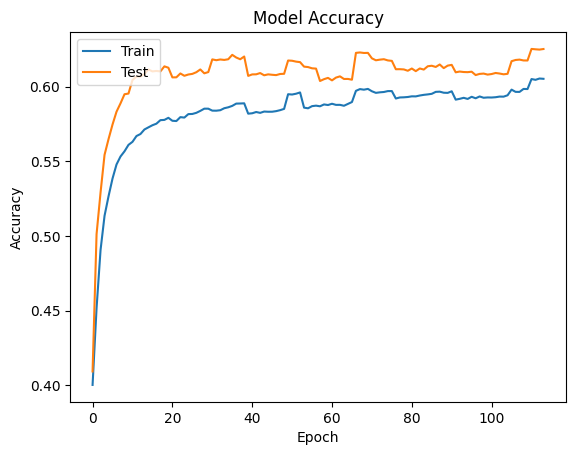

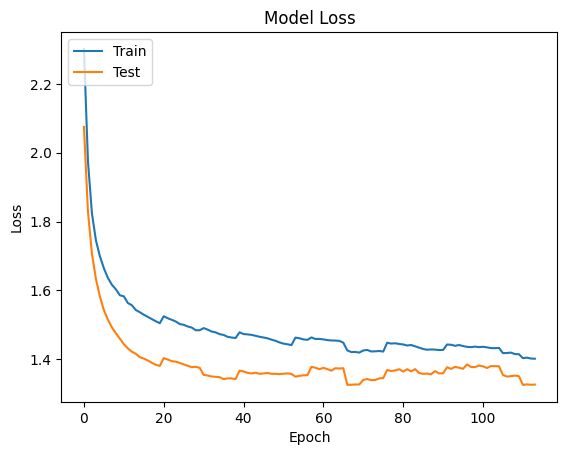

In [ ]:
# summarize history for accuracy
plt.plot(history['sparse_categorical_accuracy'])
plt.plot(history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# save the model parameters
model.save('saved_models/my_model_2_22_2023')

### Evaluate predictions

In [ ]:
# load model if necessary
model = tf.keras.models.load_model('saved_models/my_model_2_22_2023', compile=False)

Chunk all test data for input into the model:

In [ ]:
for game in test_games:
    x_subEvent_test, x_player_test, x_numeric_test, y_test = chunk_data(game,
                                                                        num_timesteps,
                                                                        playerID0index)

Evaluate test predictions:

In [ ]:
y_pred = model.predict(x={'numeric_input': x_numeric_test,
                          'subevent_input': x_subEvent_test,
                          'player_input': x_player_test})

54/54 [==============================] - 0s 2ms/step


In [ ]:
def convert_probs2classification(preds):
    """Convert the model's probabilistic predictions to their most likely class"""
    classes = np.array([])
    for timestep in preds:
        classes = np.append(classes, int(timestep.argmax()))
    return classes.astype(int)

class_preds = convert_probs2classification(y_pred)

It is possible that not all subevents are included in our test set. In this case, filter the relevant subevents so that it is possible to use sklearn's classification report:

In [ ]:
target_names=['Air Duel', 'Ground Attacking Duel', 'Ground Defending Duel',
              'Ground loose ball duel', 'Foul', 'Hand Foul', 'Late Card Foul',
              'Out of Game Foul', 'Protest', 'Simulation', 'Time Lost Foul',
              'Violent Foul', 'Corner', 'Free Kick', 'Free Kick Cross',
              'Free Kick Shot', 'Goal Kick', 'Penalty', 'Throw in',
              'Goalkeeper Leaving Line', 'Ball Out of the Field', 'Whistle',
              'Offside', 'Acceleration','Clearance', 'Touch', 'Cross',
              'Hand Pass', 'Head Pass','High Pass', 'Launch', 'Simple Pass',
              'Smart Pass', 'Reflexes', 'Save Attempt', 'Shot']
filtered_target_names = [target_names[i] for i in np.unique(y_test)]

In [ ]:
# Note that an error is thrown when calculating precision and F-score for
# classes that are never predicted

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, class_preds)))

print('\nClassification Report\n')
print(classification_report(y_test,
                            class_preds,
                            target_names=filtered_target_names))


Accuracy: 0.61


Classification Report

                         precision    recall  f1-score   support

               Air Duel       0.84      0.62      0.71       142
  Ground Attacking Duel       0.98      0.57      0.72       106
  Ground Defending Duel       1.00      0.43      0.61       106
 Ground loose ball duel       0.91      0.50      0.65        86
                   Foul       0.24      0.33      0.28        15
              Hand Foul       0.00      0.00      0.00         1
                Protest       0.00      0.00      0.00         1
         Time Lost Foul       0.00      0.00      0.00         1
                 Corner       0.83      1.00      0.91        10
              Free Kick       0.94      1.00      0.97        16
        Free Kick Cross       0.50      1.00      0.67         1
              Goal Kick       0.78      0.64      0.70        22
                Penalty       0.00      0.00      0.00         1
               Throw in       0.88      0.91    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Yay! We're achieving approximately 60% accuracy across all 36 classes. However, the precision and recall fluctuate significantly among different classes. While there's a wealth of analysis awaiting to delve into metrics for each subevent, let's now pivot toward our primary objective: generating player embeddings using our now trained model.